In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath
import networkx as nx

from metal.label_model import LabelModel
from metal.label_model.learn_deps import DependencyLearner

from metal.label_model.graph_utils import generate_edges
from metal.label_model.graph_utils import JunctionTree
from metal.label_model.graph_utils import DependenciesGraph
from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Data by Passing in Edge List

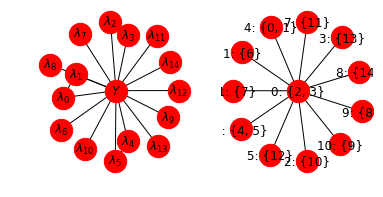

In [2]:
M = 15
N = 1000 #not used
MAX_CLIQUE_SIZE = 2
NUM_CLIQUES = 3
K = 2

# Set Graph Structure
EDGES = generate_edges(M, MAX_CLIQUE_SIZE, NUM_CLIQUES)
deps_graph = DependenciesGraph(M, EDGES)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
deps_graph.draw()


#Generate Data
data = DataGenerator(
    N,
    M,
    k=K,
    abstains=False,
    deps_graph=deps_graph,
    class_balance=0.5
)
plt.subplot(1,2,2)
data.jt.draw()

#Generate Samples for Y and L
L, Y = data.generate_label_matrix(N)
class_balance = data.get_class_balance()

### Majority Vote

In [3]:
L_conflict = 2*(L-1.5)
Y_conflict = 2*(Y-1.5)

print ("Accuracy:  ", np.mean(np.sign(np.mean(L_conflict, axis=1)) == Y_conflict))

Accuracy:   0.46


## True Dependencies

In [11]:
lm_true = LabelModel(k=K)
lm_true.train(
    L_train=L,
    class_balance=class_balance,
    abstains = False,
    deps = EDGES,
    lr=1e-6,
    n_epochs=10000,
    print_every=1000
)

lm_true.score(X=L,Y=Y)

Estimating Z...
[E:0]	Train Loss: 396.26995850
[E:1000]	Train Loss: 86.68231964
[E:2000]	Train Loss: 46.87092590
[E:3000]	Train Loss: 34.38904572
[E:4000]	Train Loss: 28.90124702
[E:5000]	Train Loss: 26.01483917
[E:6000]	Train Loss: 24.31808853
[E:7000]	Train Loss: 23.24205971
[E:8000]	Train Loss: 22.52081680
[E:9000]	Train Loss: 22.01627731
[E:9999]	Train Loss: 21.65123749
Finished Training
Accuracy: 0.889


0.889

##  No Dependencies

In [14]:
lm_ind = LabelModel(k=K)
lm_ind.train(
    L_train=L,
    class_balance=class_balance,
    abstains = False,
    deps = [],
    lr=1e-6,
    n_epochs=10000,
    print_every=1000
)

lm_ind.score(X=L,Y=Y)

Estimating Z...
[E:0]	Train Loss: 222.64764404
[E:1000]	Train Loss: 58.88888931
[E:2000]	Train Loss: 31.55049133
[E:3000]	Train Loss: 22.37073135
[E:4000]	Train Loss: 18.19259071
[E:5000]	Train Loss: 15.92838097
[E:6000]	Train Loss: 14.54863071
[E:7000]	Train Loss: 13.63078403
[E:8000]	Train Loss: 12.97539330
[E:9000]	Train Loss: 12.47830200
[E:9999]	Train Loss: 12.08110619
Finished Training
Accuracy: 0.854


0.854

## Dependency Learning with RPCA

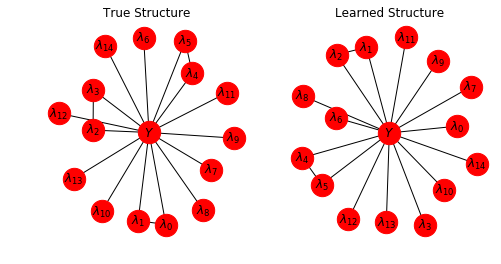

In [18]:
L_conflict = 2*(L-1.5)
Y_conflict = 2*(Y-1.5)

O = np.dot(L_conflict.T,L_conflict)/(N-1)
accuracies = np.array([np.mean(L_conflict[:,i] == Y_conflict) for i in range(M)])
mu_from_acc = 2*accuracies - 1
sig = O - np.outer(mu_from_acc,mu_from_acc)
sig_inv = np.linalg.pinv(sig)

dl = DependencyLearner(M,sig_inv)
edges_est = dl.edges_from_rpca(thresh=0.13)
deps_graph_est = DependenciesGraph(M, edges_est)


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('True Structure')
deps_graph.draw()
plt.subplot(1,2,2)
plt.title('Learned Structure')
deps_graph_est.draw()

In [19]:
for i in range(M):
        edges_est.append((i,M))

lm_deps = LabelModel(k=K)
lm_deps.train(
    L_train=L,
    class_balance=class_balance,
    abstains = False,
    deps = edges_est,
    lr=1e-2,
    n_epochs=10000,
    print_every=1000
)

lm_deps.score(X=L,Y=Y)

Estimating Z...
[E:0]	Train Loss: 258.22851562
[E:1000]	Train Loss: 10.72240257
[E:2000]	Train Loss: 10.72236538
[E:3000]	Train Loss: 10.72236538
[E:4000]	Train Loss: 10.72236538
[E:5000]	Train Loss: 10.72236538
[E:6000]	Train Loss: 10.72236538
[E:7000]	Train Loss: 10.72236538
[E:8000]	Train Loss: 10.72236347
[E:9000]	Train Loss: 10.72236538
[E:9999]	Train Loss: 10.72236347
Finished Training
Accuracy: 0.893


0.893